In [1]:
import numpy as np; import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr

In [2]:
#indir="/Users/a355905/Desktop/Intelligent_Immunity/Data/RNA/python"
#rawfile="/".join([indir,"20220413_rnadata_all_intimmunity.csv"])
rawdata=pd.read_csv("20220413_rnadata_all_intimmunity.csv",index_col=0)

In [3]:
##Functions and dataset class

def convert(xarray,cap=False):
    yarray=np.copy(xarray)
    for i,x in enumerate(xarray):
        if x=='Undetermined' and cap:
            yarray[i]=cap
        elif x!='Undetermined':
            yarray[i]=float(x)
    return yarray

class dataset:
    def __init__(self,indata): #initialize data set
        self.rawdata=indata
        self.genes=self.rawdata.iloc[4:93,0]; self.ngenes=len(self.genes)
        self.hgenes=self.genes[84:]
        self.nsamples=100
        self.ct=self.rawdata.iloc[4:93,2:].to_numpy(copy=True);
        self.hkeep=self.rawdata.iloc[88:93,2:].to_numpy(copy=True)
        for j in np.arange(np.shape(self.ct)[1]): #converts undetermined results into 40 (max CT cycles)
            self.ct[:,j]=convert(self.ct[:,j],40)
            self.hkeep[:,j]=convert(self.hkeep[:,j],40)
        self.plate=np.array([int(x) for x in rawdata.loc['Plate'][2:]])
        self.lps=rawdata.loc['LPS'][2:].to_numpy(copy=True)
        self.lineage=rawdata.loc['Lineage'][2:].to_numpy(copy=True)
        self.cap=40
        self.lindex=np.array(['ZEUS','POSEIDON','HADES','HERA','DEMETER','ATHENA','APHRODITE','ARTEMIS','APOLLO','HERMES','DIONYSUS','ARES'])
        self.letter=np.array(['A','B','C','D','E','F','G','H','I','J','K','L'])
    def housekeeping_normalize(self,hkgene='B2M'):
        self.norm=np.copy(self.ct);
        hkidx=self.hgenes==hkgene
        tmphk=self.hkeep[hkidx,:]
        for j in np.arange(self.nsamples):
            self.norm[:,j]=np.subtract(tmphk[0,j],self.norm[:,j]); #normalize every sample to housekeeping gene of choice
    def mean_analyze(self):
        self.mean_norm=np.copy(self.norm);
        posidx=self.lps=='YES'; negidx=self.lps=='NO'
        tmppos=self.norm[:,posidx]; tmpneg=self.norm[:,negidx]
        for i in np.arange(self.ngenes):
            tmppos[i,:]=np.subtract(tmppos[i,:],np.mean(tmppos[i,:])) #normalize positive samples to mean of positive samples for each gene
            tmpneg[i,:]=np.subtract(tmpneg[i,:],np.mean(tmpneg[i,:])) #normalize positive samples to mean of positive samples for each gene
        self.mean_norm[:,posidx]=tmppos; self.mean_norm[:,negidx]=tmpneg
    def paired_mean_analyze(self): #analyze means by pairwise comparison, using corresponding LPS +/- samples
        self.paired_norm=np.zeros((self.ngenes,int(self.nsamples/2)))
        posidx=self.lps=='YES'; negidx=self.lps=='NO'
        tmppos=self.norm[:,posidx]; tmpneg=self.norm[:,negidx]
        tmp=np.zeros(np.shape(tmppos))
        for i in np.arange(self.ngenes):
            self.paired_norm[i,:]=np.subtract(tmppos[i,:],tmpneg[i,:]) ##Use for PCA plots##
            #tmp[i,:]=np.subtract(tmppos[i,:],tmpneg[i,:])
            #self.paired_norm[i,:]=np.subtract(tmp[i,:],np.mean(tmp[i,:]))
    def view_skew(self,labels,bias,mode='all',save=False):
        fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes([0.25,0.25,0.65,0.65]);    
        gplabels=np.unique(labels);
        mdist=0; dist=0
        for i,x in enumerate(gplabels):
            tmpidx=labels==x
            pairidx=tmpidx[:50]
            if mode=='all':
                tmpdata=np.ndarray.flatten(self.mean_norm[:,tmpidx])
            elif mode=='gene':
                tmpdata=np.mean(self.mean_norm[:,tmpidx],axis=1)
            elif mode=='sample':
                tmpdata=np.mean(self.mean_norm[:,tmpidx],axis=0)
            elif mode=='pair_all':
                tmpdata=np.ndarray.flatten(self.paired_norm[:,pairidx])
            elif mode=='pair_gene':
                tmpdata=np.mean(self.paired_norm[:,pairidx],axis=1)
            elif mode=='pair_sample':
                tmpdata=np.mean(self.paired_norm[:,pairidx],axis=0)
            print("{} mean: {:1.3f}".format(x,np.mean(tmpdata)))
            print("{} max: {:1.3f}".format(x,np.max(tmpdata)))
            print("{} min: {:1.3f}\n".format(x,np.min(tmpdata)))
            plt.scatter(i*np.ones(len(tmpdata)),tmpdata)
            plt.plot(i,np.mean(tmpdata),color='k',marker='x',ms=10)
            mdist+=np.mean(tmpdata)**2;
            dist+=np.sum(np.power(tmpdata,2))
        plt.plot([0,len(gplabels)],[0,0],'k--')
        plt.xticks(np.arange(len(gplabels)),gplabels,rotation=90,fontsize=12);
        ax.set_xlabel('{}'.format(bias),fontsize=16)
        ax.set_ylabel('Deviation from Mean',fontsize=16)
        print("Total distance of means: {:1.3f}".format(mdist))
        print("Total distance of points: {:1.3f}".format(dist))
        if save: 
            outname="_".join(['20221110','rna',bias,'bias',mode])
            plt.savefig(".".join([outname,'png']))
    def lps_test(self,prt=True): #Compare RNA levels by pairwise increase from LPS challenge
        posidx=self.lps=='YES'; negidx=self.lps=='NO'
        self.fold_change=np.zeros(self.ngenes); self.pvalue=np.zeros(self.ngenes);
        tmppos=self.norm[:,posidx]; tmpneg=self.norm[:,negidx]
        for i in np.arange(self.ngenes):
            tmp_diff=np.mean(np.subtract(tmppos[i,:],tmpneg[i,:]))
            self.fold_change[i]=np.power(2,tmp_diff)
            tmp,self.pvalue[i]=sts.ttest_rel(tmppos[i,:],tmpneg[i,:],nan_policy='omit')
        fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
        tmpx=self.fold_change; #tmpx=np.log10(self.lps['Fold_Change'])
        tmpy=np.multiply(np.log10(self.pvalue),-1)
        plt.scatter(tmpx,tmpy)
        plt.xlabel('Fold Change',fontsize=16); plt.ylabel('P Value (-log10)',fontsize=16)
        if prt:
            output=np.zeros((self.ngenes,2));
            output[:,0]=self.fold_change; output[:,1]=tmpy
            out=pd.DataFrame(output,index=self.genes,columns=["Fold Change","P Value (-Log10)"])
            out.to_csv("20221110_ttestResults_rna.csv",sep=",",index=True)

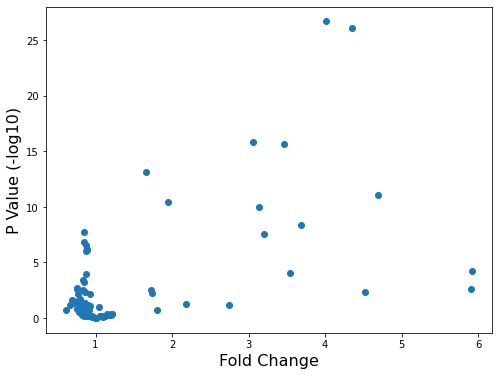

In [4]:
##Read in dataset and process
rna=dataset(rawdata)
rna.housekeeping_normalize()
rna.mean_analyze()
rna.paired_mean_analyze()
rna.lps_test()

Principal components variance
PC 1: 13.6% of variance
PC 2: 11.2% of variance
PC 3: 10.0% of variance
PC 4: 8.7% of variance
PC 5: 7.4% of variance
PC 6: 5.9% of variance
PC 7: 4.8% of variance
PC 8: 3.8% of variance
PC 9: 3.6% of variance
PC 10: 3.3% of variance


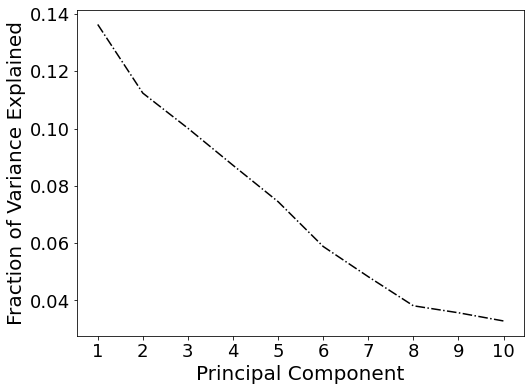

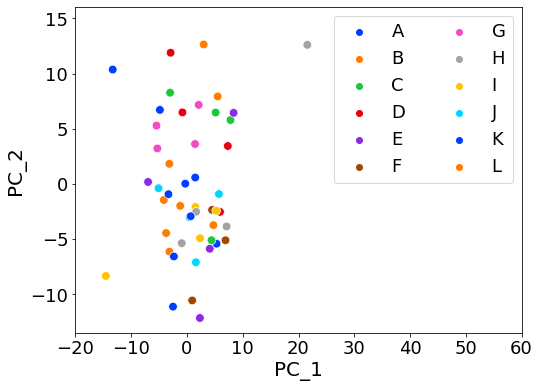

In [5]:
##Principal Component Analysis

#Pick data type to enter; 'norm' gives data group normalized, 'paired' gives data pairwise normalized
datatype='paired'
if datatype=='norm':
    tmpall=np.transpose(np.copy(rna.norm)) #uses normalized data, not pairwise normalized data
elif datatype=='paired':
    tmpall=np.transpose(np.copy(rna.paired_norm)) #uses pairwise normalized data

#Run PCA
ncomp=10
pca=PCA(n_components=ncomp)
pca.fit(tmpall)
print('Principal components variance')
for i,x in enumerate(pca.explained_variance_ratio_):
    print("PC {}: {:2.1f}% of variance".format(i+1,x*100))
pcout=pca.transform(tmpall);

#graph of variance explained by principal components
plt.rcParams.update({'font.size': 18})
fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
plt.plot(np.arange(1,ncomp+1),pca.explained_variance_ratio_,'k-.')
ax.set_xlabel('Principal Component')
ax.set_xticks(np.arange(1,11))
ax.set_xlabel('Principal Component',fontsize=20)
#ax.set_ylim([0,1])
ax.set_ylabel('Fraction of Variance Explained',fontsize=20)
#plt.savefig('pca/20230125_rna_pca_varExplained_norm.png')

#Visualize
ax1=0; ax2=1; #Edit here; choose principal components to visualize (PC is 1 higher than index)
labels='lineage'; #Edit here; choose 'lineage', 'plate', or 'lps' to label colors across respective 

if labels=='lineage':
    #huey=rna.lineage #only use [:50] if using paired norm
    huey=np.array([rna.letter[np.where(x==rna.lindex)][0][0] for x in rna.lineage])
elif labels=='plate':
    huey=rna.plate #only use [:50] if using paired norm
elif labels=='lps':
    huey=rna.lps#can't use with paired norm 
if datatype=='paired':
    huey=huey[:50]
fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
sns.scatterplot(x=pcout[:,ax1],y=pcout[:,ax2],hue=huey,palette='bright',s=75)
ax.set_xlabel('PC_{}'.format(str(ax1+1)),fontsize=20); ax.set_ylabel('PC_{}'.format(str(ax2+1)),fontsize=20)
outname='_'.join(['20230124','v4','paired','pca','pc{}pc{}'.format(str(ax1+1),str(ax2+1)),labels,'plot.png'])
plt.legend(loc='upper right',ncol=2)
ax.set_xlim([-20,60]);
#plt.savefig("/".join(['pca',outname]))

In [27]:
##Check correlations of principal components with plate, lineage, etc.
#Only works if principal component analysis has been run in 'norm' mode
tmpplate=np.copy(rna.plate)
tmpplate[tmpplate==3]==-1; tmpplate[tmpplate==5]=3; tmpplate[tmpplate==-1]=5 #rearranges plate numbers to better align with PC axis
tmplps=rna.lps=="YES"

#converts lineage names to numbers
tmplin=np.copy(rna.lineage); tmplin[tmplin=="ZEUS"]=1; tmplin[tmplin=="POSEIDON"]=2; tmplin[tmplin=="HADES"]=3;
tmplin[tmplin=="HERA"]=4; tmplin[tmplin=="DEMETER"]=5; tmplin[tmplin=="ATHENA"]=6;
tmplin[tmplin=="APHRODITE"]=7; tmplin[tmplin=="ARTEMIS"]=8; tmplin[tmplin=="APOLLO"]=9;
tmplin[tmplin=="HERMES"]=10; tmplin[tmplin=="DIONYSUS"]=11; tmplin[tmplin=="ARES"]=12;

#Can change pcs investigated by changing pcx1 and pcx2; correspond to PCs, not index
pcx1=2; pcx2=3
print("Plate with PC {}:   {:1.3f}".format(pcx1,pearsonr(pcout[:,pcx1-1],tmpplate)[0]))
print("Plate with PC {}:   {:1.3f}".format(pcx2,pearsonr(pcout[:,pcx2-1],tmpplate)[0]))
print("LPS with PC {}:   {:1.3f}".format(pcx1,pearsonr(pcout[:,pcx1-1],tmplps)[0]))
print("LPS with PC {}:   {:1.3f}".format(pcx2,pearsonr(pcout[:,pcx2-1],tmplps)[0]))
print("Lineage with PC {}:  {:1.3f}".format(pcx1,pearsonr(pcout[:,pcx1-1],tmplin)[0]))
print("Lineage with PC {}:   {:1.3f}".format(pcx2,pearsonr(pcout[:,pcx2-1],tmplin)[0]))

npcs=np.shape(pcout)[1]

tmpr_lin=np.zeros(npcs); tmpr_lps=np.zeros(npcs); tmpr_plate=np.zeros(npcs)
for i in np.arange(npcs):
    tmpr_lin[i]=np.abs(pearsonr(pcout[:,i],tmplin)[0])
    tmpr_lps[i]=np.abs(pearsonr(pcout[:,i],tmplps)[0])
    tmpr_plate[i]=np.abs(pearsonr(pcout[:,i],tmpplate)[0])

fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes(); #ax=plt.axes([0.25,0.25,0.65,0.65]);
wid=0.25
tmpx=np.arange(1,npcs+1)
plt.bar(tmpx,tmpr_lps,width=wid,color='b')
plt.bar(tmpx+wid,tmpr_plate,width=wid,color='r')
plt.bar(tmpx+wid*2,tmpr_lin,width=wid,color='g')
#sns.barplot(x=tmpdf['Xcoor'],y='Data',hue='Names')
#sns.barplot(x=tmpdf.iloc[:,0].to_numpy(),y=tmpdf.iloc[:,1].to_numpy(),hue=tmpdf.iloc[:,2].to_numpy())
ax.set_xticks(tmpx)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Pearson r')
#ax.set_ylim([0,0.7])
plt.legend(['LPS','Plate','Lineage'],loc='upper right')
#plt.savefig('20230131_rna_pca_correlations.png')

#Print values to csv
#tmpdf=pd.DataFrame(data=np.transpose(np.vstack([tmpr_lps,tmpr_plate,tmpr_lin])),index=np.arange(1,ncomp+1),columns=['LPS','Plate','Lineage'])
#tmpdf.to_csv('20230125_rna_pca_correlations.csv')

ValueError: x and y must have the same length.

Plate with PC 2:   -0.185
Plate with PC 3:   0.138
Lineage with PC 2:  -0.172
Lineage with PC 3:   -0.203


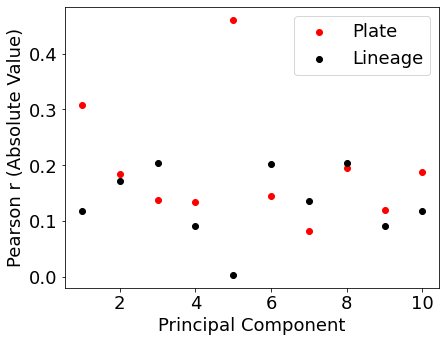

In [6]:
##Check correlations of principal components with plate, lineage, etc. for pairwise-normalized data
#Only works if principal component analysis has been run in 'paired' mode

tmpplate=np.copy(rna.plate[:50])
#tmpplate[tmpplate==3]==-1; tmpplate[tmpplate==5]=3; tmpplate[tmpplate==-1]=5 #rearranges plate numbers to better align with PC axis

#converts lineage names to numbers
tmplin=np.copy(rna.lineage)[:50]; tmplin[tmplin=="ZEUS"]=1; tmplin[tmplin=="POSEIDON"]=2; tmplin[tmplin=="HADES"]=3;
tmplin[tmplin=="HERA"]=4; tmplin[tmplin=="DEMETER"]=5; tmplin[tmplin=="ATHENA"]=6;
tmplin[tmplin=="APHRODITE"]=7; tmplin[tmplin=="ARTEMIS"]=8; tmplin[tmplin=="APOLLO"]=9;
tmplin[tmplin=="HERMES"]=10; tmplin[tmplin=="DIONYSUS"]=11; tmplin[tmplin=="ARES"]=12;

#Can change pcs investigated by changing pcx1 and pcx2; correspond to PCs, not index
pcx1=2; pcx2=3
print("Plate with PC {}:   {:1.3f}".format(pcx1,pearsonr(pcout[:,pcx1-1],tmpplate)[0]))
print("Plate with PC {}:   {:1.3f}".format(pcx2,pearsonr(pcout[:,pcx2-1],tmpplate)[0]))
print("Lineage with PC {}:  {:1.3f}".format(pcx1,pearsonr(pcout[:,pcx1-1],tmplin)[0]))
print("Lineage with PC {}:   {:1.3f}".format(pcx2,pearsonr(pcout[:,pcx2-1],tmplin)[0]))

npcs=np.shape(pcout)[1]

tmpr_lin=np.zeros(npcs); tmpr_lps=np.zeros(npcs); tmpr_plate=np.zeros(npcs)
for i in np.arange(npcs):
    tmpr_lin[i]=np.abs(pearsonr(pcout[:,i],tmplin)[0])
    tmpr_plate[i]=np.abs(pearsonr(pcout[:,i],tmpplate)[0])

fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes([0.25,0.25,0.65,0.65]);
tmpx=np.array([x+1 for x in np.arange(npcs)])
plt.scatter(tmpx,tmpr_plate,c='r')
plt.scatter(tmpx,tmpr_lin,c='k')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Pearson r (Absolute Value)')
plt.legend(['Plate','Lineage'])

In [5]:
###### PROTEIN DATA #######
#Load in data file
rawfile="20221005_FP70_signal.csv"
rawdata=pd.read_csv(rawfile)

#Fix labeling problem from excel (interprets 1E0 as 1.00x10**1.00)
rawdata.iloc[5,0]='1E0'; rawdata.iloc[6,0]='1E1'
rawdata.iloc[35,0]='3E0'; rawdata.iloc[36,0]='3E1'
rawdata.iloc[59,0]='4E0'; rawdata.iloc[60,0]='4E1'

In [6]:
##dataset class and functions for protein analysis

def scrub(inarray,name):
    tmp=np.sum(inarray=="NP")
    if tmp>0: print("Found {} missing data in sample {}".format(tmp,name))
    inarray[inarray=="NP"]=np.nan
    outarray=np.array([float(x) for x in inarray])
    return outarray

class dataset:
    def __init__(self,indata,sdilution):
        self.rawdata=indata
        self.genes=self.rawdata.columns[5:75]; self.ngenes=len(self.genes)
        self.nsamples=78
        self.signal=np.zeros((self.nsamples,len(self.genes)))
        self.standards=np.zeros((9,len(self.genes)))
        self.max_std=scrub(self.rawdata.iloc[-1,5:75],'Maximums')
        self.sample_dilution=sdilution
        self.pgml=np.zeros(np.shape(self.signal));
        self.lineage=self.rawdata['Lineage'][1:79].to_numpy(copy=True)
        self.plate=self.rawdata['Plate'][1:79].to_numpy(copy=True)
        for i,x in enumerate(self.genes):
            tmp=scrub(self.rawdata[x][1:-1].to_numpy(copy=True),x)
            self.signal[:,i]=tmp[:78]
            self.standards[:,i]=tmp[78:]
        self.lindex=np.array(['ZEUS','POSEIDON','HADES','HERA','DEMETER','ATHENA','APHRODITE','ARTEMIS','APOLLO','HERMES','DIONYSUS','ARES'])
        self.letter=np.array(['A','B','C','D','E','F','G','H','I','J','K','L'])
    def signal_interpolate(self,verbose=0): #convert signal into pg/mL using standards
        dilution=np.zeros(8); dilution[0]=1; #dilution vector of repeated 1:3 dilutions
        for i in np.arange(1,8): dilution[i]=dilution[i-1]*0.333
        if verbose:
            self.regression=np.zeros((6,self.ngenes))
            rtitles=['slope','intercept','pearsonr','pvalue','stderr','intercept_stderr']
        for i in np.arange(self.ngenes):
        #for i in np.arange(1):
            bkg=self.standards[8,i]
            tstd=np.log10(np.subtract(self.standards[:8,i],bkg)) #background subtract
            tdil=np.log10(np.multiply(dilution,self.max_std[i])); #Use max signal (dil=1.00) pg/mL number for curve
            tmp2=np.subtract(self.signal[:,i],bkg) #background subtraction
            tmp2[tmp2<=0]=1
            tmp=np.log10(tmp2)
            tmp_reg=sts.linregress(tstd[1:],tdil[1:])
            if tmp_reg.rvalue<0.95: print("R value less than 0.95 for {} (r={:1.3f})".format(self.genes[i],tmp_reg.rvalue))
            if verbose:
                #print("y={:1.3f}*x+{:1.3f} r2={:1.3f}".format(tmp_reg.slope,tmp_reg.intercept,tmp_reg.rvalue))
                self.regression[:,i]=np.array([tmp_reg.slope,tmp_reg.intercept,tmp_reg.rvalue,tmp_reg.pvalue,tmp_reg.stderr,tmp_reg.intercept_stderr])
                fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
                plt.scatter(tstd[1:],tdil[1:])
                xline=np.array([3,8])
                yline=np.add(np.multiply(xline,tmp_reg.slope),tmp_reg.intercept)
                plt.plot(xline,yline,'k--')
                plt.xlabel('Log10(Signal)',fontsize=16); plt.ylabel('Log10(Concentration)',fontsize=16)
            tmp[tmp>tstd[1]]=tstd[1]; tmp[tmp<tstd[-1]]=tstd[-1] #cap outliers at max/min value
            #Following line, convert signal to pg/mL using linear regression, then raise to power of 10, then multiply by sample dilution
            self.pgml[:,i]=np.multiply(np.power(10,np.add(np.multiply(tmp,tmp_reg.slope),tmp_reg.intercept)), self.sample_dilution)
        if verbose:
            tmpdata=pd.DataFrame(self.regression,columns=self.genes,index=rtitles)
            tmpdata.to_csv('interpolation_results_protein.csv')
    def mean_analyze(self):
        self.mean_norm=np.copy(self.pgml);
        posidx=self.lps['Index']=='YES'; negidx=self.lps['Index']=='NO'
        tmppos=self.pgml[posidx,:]; tmpneg=self.pgml[negidx,:]
        for i in np.arange(self.ngenes):
            tmppos[:,i]=np.divide(tmppos[:,i],np.nanmean(tmppos[:,i])) #normalize positive samples to mean of positive samples for each gene
            tmpneg[:,i]=np.divide(tmpneg[:,i],np.nanmean(tmpneg[:,i])) #normalize positive samples to mean of positive samples for each gene
        self.mean_norm[posidx,:]=tmppos; self.mean_norm[negidx,:]=tmpneg
    def nc_normalize(self): #normalize to negative control data for each sample
        self.norm=np.copy(self.pgml);
        negctl=fp70.pgml[:,fp70.genes=='NEG']
        #normvec=np.divide(negctl,sts.mstats.gmean(negctl))[:,0]
        normvec=np.divide(negctl,np.mean(negctl))[:,0]
        for i in np.arange(self.ngenes):
            self.norm[:,i]=np.divide(self.pgml[:,i],normvec) #normalize samples by factors set by negative control
    def paired_mean_analyze(self):
        self.paired_norm=np.zeros((int(self.nsamples/2),self.ngenes))
        posidx=self.lps['Index']=='YES'; negidx=self.lps['Index']=='NO'
        tmppos=self.norm[posidx,:]; tmpneg=self.norm[negidx,:]
        tmp=np.zeros(np.shape(tmppos))
        for i in np.arange(self.ngenes):
            self.paired_norm[:,i]=np.divide(tmppos[:,i],tmpneg[:,i]) #use for pca 
            #tmp[:,i]=np.divide(tmppos[:,i],tmpneg[:,i]) #use for bias calculations
            #self.paired_norm[:,i]=np.divide(tmp[:,i],np.nanmean(tmp[:,i]))
    def view_skew(self,labels,bias,mode='all',save=False):
        fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes([0.25,0.25,0.65,0.65]);    
        gplabels=np.unique(labels);
        mdist=0; dist=0
        for i,x in enumerate(gplabels):
            tmpidx=labels==x
            pairidx=tmpidx[::2]
            if mode=='all':
                tmpdata=np.ndarray.flatten(self.mean_norm[tmpidx,:])
            elif mode=='gene':
                tmpdata=np.nanmean(self.mean_norm[tmpidx,:],axis=0)
            elif mode=='sample':
                tmpdata=np.nanmean(self.mean_norm[tmpidx,:],axis=1)
            elif mode=='pair_all':
                tmpdata=np.ndarray.flatten(self.paired_norm[pairidx,:])
            elif mode=='pair_gene':
                tmpdata=np.nanmean(self.paired_norm[pairidx,:],axis=0)
            elif mode=='pair_sample':
                tmpdata=np.nanmean(self.paired_norm[pairidx,:],axis=1)
            tmpdata=np.log2(tmpdata)
            if bias=='Lineage':
                i=np.where(self.lindex==x)[0][0]
            print("{} mean: {:1.3f}".format(x,np.nanmean(tmpdata)))
            print("{} max: {:1.3f}".format(x,np.nanmax(tmpdata)))
            print("{} min: {:1.3f}\n".format(x,np.nanmin(tmpdata)))
            plt.scatter(i*np.ones(len(tmpdata)),tmpdata)
            plt.plot(i,np.nanmean(tmpdata),color='k',marker='x',ms=10)
            mdist+=np.nanmean(tmpdata)**2
            dist+=np.nansum(np.power(tmpdata,2))
        if bias=='Lineage':
            gplabels=self.letter;
        plt.plot([0,len(gplabels)],[0,0],'k--')
        plt.xticks(np.arange(len(gplabels)),gplabels,fontsize=12);
        ax.set_xlabel('{}'.format(bias),fontsize=16)
        ax.set_ylabel('Deviation from Mean',fontsize=16)
        print("Total distance of means: {:1.3f}".format(mdist))
        print("Total distance of points: {:1.3f}".format(dist))
        if save: 
            outname="_".join(['20221110','protein',bias,'bias',mode])
            plt.savefig(".".join([outname,'png']))
    def lps_test(self,prt=True):
        self.lps=dict()
        self.lps['Index']=self.rawdata['LPS'][1:79].to_numpy(copy=True)
        posmask=self.lps['Index']=='YES'; negmask=self.lps['Index']=='NO';
        self.lps['Fold_Change']=np.zeros(self.ngenes)
        self.lps['p_value']=np.zeros(self.ngenes)
        for i in np.arange(self.ngenes):
            tmppos=self.norm[posmask,i]; tmpneg=self.norm[negmask,i]
            self.lps['Fold_Change'][i]=np.nanmean(np.divide(tmppos,tmpneg))
            tmp,self.lps['p_value'][i]=sts.ttest_rel(tmppos,tmpneg,nan_policy='omit')
        fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
        tmpx=self.lps['Fold_Change']; #tmpx=np.log10(self.lps['Fold_Change'])
        tmpy=np.multiply(np.log10(self.lps['p_value']),-1)
        plt.scatter(tmpx,tmpy)
        plt.xlabel('Fold Change',fontsize=16); plt.ylabel('P Value (-log10)',fontsize=16)
        if prt:
            output=np.zeros((70,2));
            output[:,0]=self.lps['Fold_Change']; output[:,1]=tmpy
            out=pd.DataFrame(output,index=fp70.genes,columns=["Fold Change","P Value (-Log10)"])
            out.to_csv("20221202_ttestResults.csv",sep=",",index=True)

Found 2 missing data in sample AGR2
Found 1 missing data in sample CALB1
Found 1 missing data in sample CD276
Found 1 missing data in sample CD40
Found 1 missing data in sample BSG
Found 2 missing data in sample FGFR3
Found 1 missing data in sample HBA1
Found 1 missing data in sample IL1B
Found 1 missing data in sample IL1R1
Found 1 missing data in sample IL10
Found 1 missing data in sample IL12A
Found 1 missing data in sample IL17A
Found 2 missing data in sample IL18
Found 1 missing data in sample IL1RN
Found 1 missing data in sample IL3
Found 1 missing data in sample IL5
Found 1 missing data in sample CXCL8
Found 1 missing data in sample IL9
Found 1 missing data in sample CXCL10
Found 1 missing data in sample OLR1
Found 1 missing data in sample CCL8
Found 1 missing data in sample CXCL9
Found 1 missing data in sample CCL3
Found 1 missing data in sample PCSK9
Found 1 missing data in sample PLAU
Found 1 missing data in sample TNF
Found 1 missing data in sample VEGFA


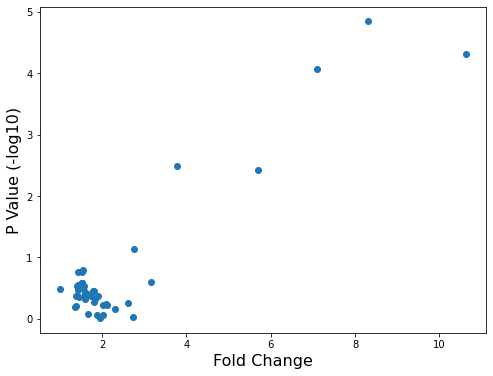

In [7]:
fp70=dataset(rawdata,2)
fp70.signal_interpolate()
fp70.nc_normalize()
fp70.lps_test(True)
fp70.mean_analyze()
fp70.paired_mean_analyze()

0
[8.15659095e-01 1.36813933e-01 2.59669252e-02 9.30804559e-03
 4.76440120e-03 3.56712290e-03 1.82831212e-03 1.16637035e-03
 3.90632624e-04 3.34579585e-04]


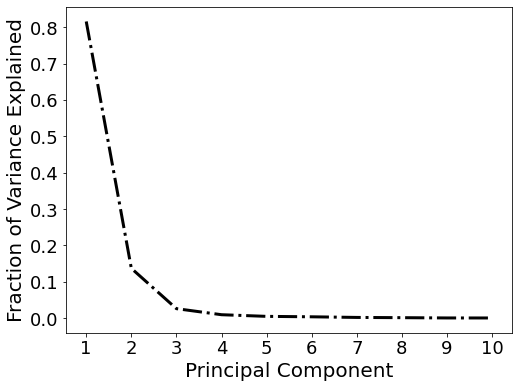

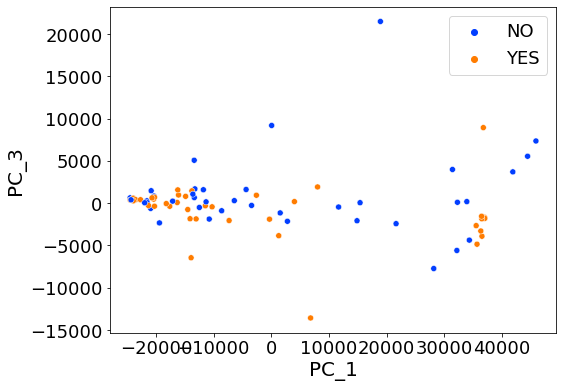

In [20]:
##PCA for unpaired (norm) or paired (paried_norm) samples

#Input variables--only need to change these
dset='norm' #options-norm,paired_norm,'raw'
ax1=0; ax2=2; #Axes to plot (Principal component -1; e.g. PC1 is ax=0)
labels='lps'; #Label to use; Can use 'lps', 'lineage', or 'plate'
save=False


def impute(xarray):
    xarray[np.isnan(xarray)]=np.nanmean(xarray)
    return xarray

#Impute missing values individually for positive and negative samples
#tmpall=np.delete(np.copy(fp70.pgml),57,1) #need to delete Negative Control, deprecated since Neg Ctl is no longer all NAN
if dset=='norm':
    tmpall=fp70.norm
if dset=='norm_out':
    tmpall=np.delete(np.copy(fp70.norm),58,0) #removes outlier from plate 4, demeter, no lps
elif dset=='paired_norm':
    tmpall=fp70.paired_norm
elif dset=='raw':
    tmpall=fp70.pgml

#Impute missing values for PCA
if dset=='norm' or dset=='raw':
    print(np.sum(np.isnan(tmpall)))
    posmask=fp70.lps['Index']=='YES'; negmask=fp70.lps['Index']=='NO';
    for i in np.arange(np.shape(tmpall)[1]):
        tmp=tmpall[:,i];
        if np.isnan(tmp[posmask]).any(): tmpall[posmask,i]=impute(tmp[posmask])
        if np.isnan(tmp[negmask]).any(): tmpall[negmask,i]=impute(tmp[negmask])
    #print(np.sum(np.isnan(tmpall)))
elif dset=='paired_norm':
    print(np.sum(np.isnan(tmpall)))
    for i in np.arange(np.shape(tmpall)[1]):
        tmp=tmpall[:,i];
        if np.isnan(tmp).any(): tmpall[:,i]=impute(tmp)
    print(np.sum(np.isnan(tmpall)))

#Run PCA
ncomp=10
pca=PCA(n_components=ncomp)
pca.fit(tmpall)
print(pca.explained_variance_ratio_)
pcout=pca.transform(tmpall);
plt.rcParams.update({'font.size': 18})
fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
plt.plot(np.arange(1,ncomp+1),pca.explained_variance_ratio_,'k-.',linewidth=3)
ax.set_xticks(np.arange(1,11))
ax.set_xlabel('Principal Component',fontsize=20)
#ax.set_ylim([0,1])
ax.set_ylabel('Fraction of Variance Explained',fontsize=20)
#plt.savefig("20230124_pca_protein_varExplained.png")

#Visualize

if labels=='lineage':
    #huey=fp70.lineage
    huey=np.array([fp70.letter[np.where(x==fp70.lindex)][0][0] for x in fp70.lineage])
elif labels=='plate':
    huey=fp70.plate
elif labels=='lps':
    huey=fp70.lps['Index']
if dset=='paired_norm': 
    huey=huey[::2] #correct color labels for paired_norm mode
elif dset=='norm_out':
    huey=np.delete(huey,58,0)
fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
if labels=='lineage': 
    sns.scatterplot(x=pcout[:,ax1],y=pcout[:,ax2],hue=huey,palette='bright',hue_order=fp70.letter)
else:
    sns.scatterplot(x=pcout[:,ax1],y=pcout[:,ax2],hue=huey,palette='bright')
ax.set_xlabel('PC_{}'.format(str(ax1+1)),fontsize=20); ax.set_ylabel('PC_{}'.format(str(ax2+1)),fontsize=20)
if save:
    outname='_'.join(['20221122','protein','pca',dset,'pc{}pc{}'.format(str(ax1+1),str(ax2+1)),labels,'plot.png'])
    plt.savefig("/".join(['pca',outname]))

0
0
[8.10196994e-01 1.15207855e-01 3.40836031e-02 2.02242940e-02
 9.38428958e-03 4.19602116e-03 2.08698678e-03 1.59759231e-03
 7.94498962e-04 6.07979059e-04]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


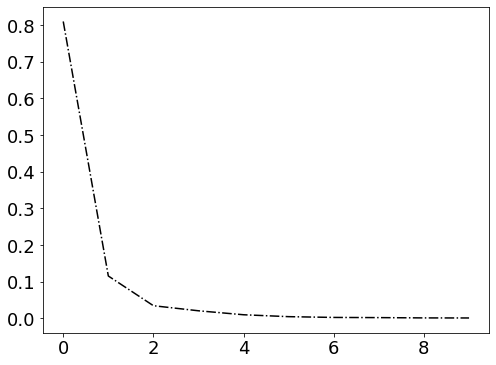

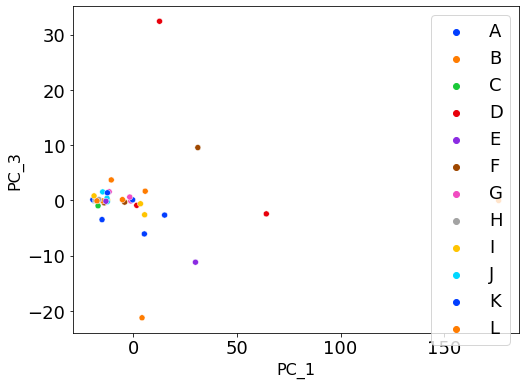

In [22]:
##PCA-paired samples

def impute(xarray):
    xarray[np.isnan(xarray)]=np.nanmedian(xarray)
    return xarray

#Impute missing values
#tmpall=np.delete(np.copy(fp70.paired_norm),57,1)
tmpall=fp70.paired_norm
print(np.sum(np.isnan(tmpall)))
for i in np.arange(np.shape(tmpall)[1]):
    tmp=tmpall[:,i];
    if np.isnan(tmp).any(): tmpall[:,i]=impute(tmp)
print(np.sum(np.isnan(tmpall)))

#Run PCA
ncomp=10
pca=PCA(n_components=ncomp)
pca.fit(tmpall)
print(pca.explained_variance_ratio_)
pcout=pca.fit_transform(tmpall);
fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
plt.plot(np.arange(ncomp),pca.explained_variance_ratio_,'k-.')

#Visualize
ax1=0; ax2=2;
labels='lineage';

if labels=='lineage':
    #huey=fp70.lineage[::2]
    huey=np.array([fp70.letter[np.where(x==fp70.lindex)][0][0] for x in fp70.lineage])[::2]
elif labels=='plate':
    huey=fp70.plate[::2]
elif labels=='lps':
    huey=fp70.lps['Index'][::2]       
fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
if labels=='lineage':
    sns.scatterplot(pcout[:,ax1],pcout[:,ax2],hue=huey,palette='bright',hue_order=fp70.letter)
else:
    sns.scatterplot(pcout[:,ax1],pcout[:,ax2],hue=huey,palette='bright')
ax.set_xlabel('PC_{}'.format(str(ax1+1)),fontsize=16); ax.set_ylabel('PC_{}'.format(str(ax2+1)),fontsize=16)
outname='_'.join(['20221122','protein','pca','pc{}pc{}'.format(str(ax1+1),str(ax2+1)),labels,'paired','plot.png'])
#plt.savefig("/".join(['pca',outname]))

In [17]:
##Gene output for heatmap
genelist=['CXCL3','CXCL5','CXCL8','CCL2','CCL22','CXCL10',
          'CSF3','IL6','IL1B','TNF']
posmask=fp70.lps['Index']=='YES'; negmask=fp70.lps['Index']=='NO';
snames=fp70.rawdata.iloc[1:79,0];
snames2=np.hstack([snames[negmask],snames[posmask]])
geneidx=[np.where(fp70.genes==x)[0][0] for x in genelist]
outarray=np.zeros((np.shape(fp70.pgml)[0],len(genelist)))
for i,j in enumerate(geneidx):
    outarray[:39,i]=np.log2(fp70.pgml[negmask,j]);
    outarray[39:,i]=np.log2(fp70.pgml[posmask,j]);
outarray=np.transpose(outarray)
out2=pd.DataFrame(outarray,columns=snames2,index=genelist)
#out2.to_csv('20221202_fp70_output_siggenes.csv',sep=',')

In [18]:
##Gene output for comparative RNA/Protein fold change
genelist=['CSF3','CCL2','CXCL8','IL6']
posmask=fp70.lps['Index']=='YES'; negmask=fp70.lps['Index']=='NO';
snames=fp70.rawdata.iloc[1:79,0];
snames2=snames[posmask]
geneidx=[np.where(fp70.genes==x)[0][0] for x in genelist]
outarray=np.zeros((int(np.shape(fp70.pgml)[0]/2),len(genelist)))
for i,j in enumerate(geneidx):
    outarray[:,i]=np.divide(fp70.norm[posmask,j],fp70.norm[negmask,j]);
outarray=np.transpose(outarray)
out2=pd.DataFrame(outarray,columns=snames2,index=genelist)
#out2.to_csv('20230124_fp70_foldchange_output.csv',sep=',')

Plate with PC 1:   -0.098
Plate with PC 2:   0.112
LPS with PC 2:   -0.086
LPS with PC 4:   0.324
Lineage with PC 1:  0.256
Lineage with PC 2:   -0.080


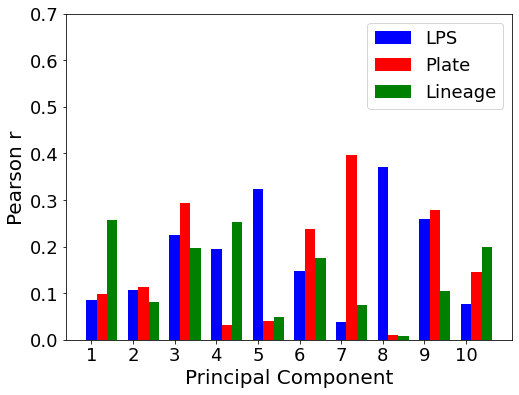

In [21]:
##Check correlations of principal components with plate, lineage, etc.
#Run pca on 'norm' samples first (not pairwise)
tmpplate=np.array([int(x) for x in np.copy(fp70.plate)])
#tmpplate[tmpplate==3]==-1; tmpplate[tmpplate==5]=3; tmpplate[tmpplate==-1]=5 #rearranges plate numbers to better align with PC axis
tmplps=np.zeros(len(fp70.lps['Index']))
tmplps[fp70.lps['Index']=="YES"]=1; 

#converts lineage names to numbers
tmplin=np.copy(fp70.lineage); tmplin[tmplin=="ZEUS"]=1; tmplin[tmplin=="POSEIDON"]=2; tmplin[tmplin=="HADES"]=3;
tmplin[tmplin=="HERA"]=4; tmplin[tmplin=="DEMETER"]=5; tmplin[tmplin=="ATHENA"]=6;
tmplin[tmplin=="APHRODITE"]=7; tmplin[tmplin=="ARTEMIS"]=8; tmplin[tmplin=="APOLLO"]=9;
tmplin[tmplin=="HERMES"]=10; tmplin[tmplin=="DIONYSUS"]=11; tmplin[tmplin=="ARES"]=12;


print("Plate with PC 1:   {:1.3f}".format(pearsonr(pcout[:,0],tmpplate)[0]))
print("Plate with PC 2:   {:1.3f}".format(pearsonr(pcout[:,1],tmpplate)[0]))
print("LPS with PC 2:   {:1.3f}".format(pearsonr(pcout[:,0],tmplps)[0]))
print("LPS with PC 4:   {:1.3f}".format(pearsonr(pcout[:,4],tmplps)[0]))
print("Lineage with PC 1:  {:1.3f}".format(pearsonr(pcout[:,0],tmplin)[0]))
print("Lineage with PC 2:   {:1.3f}".format(pearsonr(pcout[:,1],tmplin)[0]))


#Creates a plot of PCs vs correlation for lineage, lps treatment, and plate
npcs=np.shape(pcout)[1]

tmpr_lin=np.zeros(npcs); tmpr_lps=np.zeros(npcs); tmpr_plate=np.zeros(npcs)
for i in np.arange(npcs):
    tmpr_lin[i]=np.abs(pearsonr(pcout[:,i],tmplin)[0])
    tmpr_lps[i]=np.abs(pearsonr(pcout[:,i],tmplps)[0])
    tmpr_plate[i]=np.abs(pearsonr(pcout[:,i],tmpplate)[0])
#tmpdf=pd.DataFrame(data=np.transpose(np.vstack([tmpr_lps,tmpr_plate,tmpr_lin])),index=np.arange(1,ncomp+1),columns=['LPS','Plate','Lineage'])
tmpdata=np.hstack([tmpr_lps,tmpr_plate,tmpr_lin])
tmpnames=np.hstack([np.repeat('LPS',ncomp),np.repeat('Plate',ncomp),np.repeat('Lineage',ncomp)])
tmpxcoor=np.hstack([np.arange(1,ncomp+1),np.arange(1,ncomp+1),np.arange(1,ncomp+1)])
tmpdf=pd.DataFrame(data=np.transpose(np.vstack([tmpxcoor,tmpdata,tmpnames])),columns=['Xcoor','Data','Names'])



fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();
wid=0.25
tmpx=np.arange(1,npcs+1)
plt.bar(tmpx,tmpr_lps,width=wid,color='b')
plt.bar(tmpx+wid,tmpr_plate,width=wid,color='r')
plt.bar(tmpx+wid*2,tmpr_lin,width=wid,color='g')
#sns.barplot(x=tmpdf['Xcoor'],y='Data',hue='Names')
#sns.barplot(x=tmpdf.iloc[:,0].to_numpy(),y=tmpdf.iloc[:,1].to_numpy(),hue=tmpdf.iloc[:,2].to_numpy())
ax.set_xticks(tmpx)
ax.set_xlabel('Principal Component',fontsize=20)
ax.set_ylabel('Pearson r',fontsize=20)
ax.set_ylim([0,0.7])
plt.legend(['LPS','Plate','Lineage'],loc='upper right')
plt.savefig('20230131_protein_pca_correlations.png')

#tmpdf.to_csv('20230125_fp70_pca_correlations.csv')

Plate with PC 1:   -0.380
Plate with PC 2:   0.445
Lineage with PC 1:  -0.280
Lineage with PC 2:   -0.294


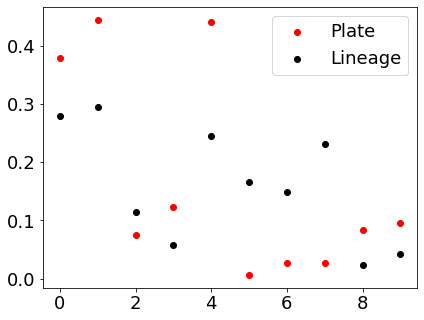

In [23]:
##Check correlations of principal components with plate, lineage, etc. for paired samples
#Run pca on 'norm_paired' (pairwise) samples first 

tmpplate=np.array([int(x) for x in fp70.plate[::2]])
#tmpplate[tmpplate==3]==-1; tmpplate[tmpplate==5]=3; tmpplate[tmpplate==-1]=5 #rearranges plate numbers to better align with PC axis

#converts lineage names to numbers
tmplin=np.copy(fp70.lineage)[::2]; tmplin[tmplin=="ZEUS"]=1; tmplin[tmplin=="POSEIDON"]=2; tmplin[tmplin=="HADES"]=3;
tmplin[tmplin=="HERA"]=4; tmplin[tmplin=="DEMETER"]=5; tmplin[tmplin=="ATHENA"]=6;
tmplin[tmplin=="APHRODITE"]=7; tmplin[tmplin=="ARTEMIS"]=8; tmplin[tmplin=="APOLLO"]=9;
tmplin[tmplin=="HERMES"]=10; tmplin[tmplin=="DIONYSUS"]=11; tmplin[tmplin=="ARES"]=12;


print("Plate with PC 1:   {:1.3f}".format(pearsonr(pcout[:,0],tmpplate)[0]))
print("Plate with PC 2:   {:1.3f}".format(pearsonr(pcout[:,1],tmpplate)[0]))
print("Lineage with PC 1:  {:1.3f}".format(pearsonr(pcout[:,0],tmplin)[0]))
print("Lineage with PC 2:   {:1.3f}".format(pearsonr(pcout[:,1],tmplin)[0]))

npcs=np.shape(pcout)[1]

tmpr_lin=np.zeros(npcs); tmpr_lps=np.zeros(npcs); tmpr_plate=np.zeros(npcs)
for i in np.arange(npcs):
    tmpr_lin[i]=np.abs(pearsonr(pcout[:,i],tmplin)[0])
    tmpr_plate[i]=np.abs(pearsonr(pcout[:,i],tmpplate)[0])

fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes([0.25,0.25,0.65,0.65]);
tmpx=np.arange(npcs)
plt.scatter(tmpx,tmpr_plate,c='r')
plt.scatter(tmpx,tmpr_lin,c='k')
plt.legend(['Plate','Lineage'])



/var/folders/dy/8ln0h319305568_c74lk50m80000gr/T/ipykernel_2252/1260089942.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(8,6),facecolor='white'); ax=plt.axes();


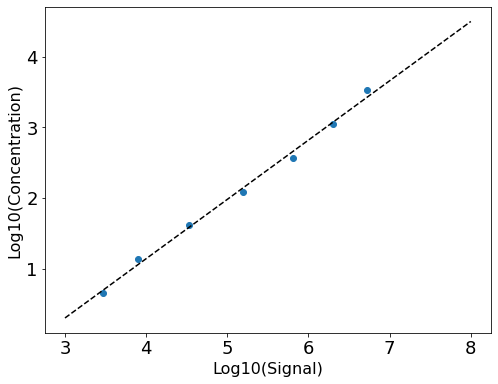

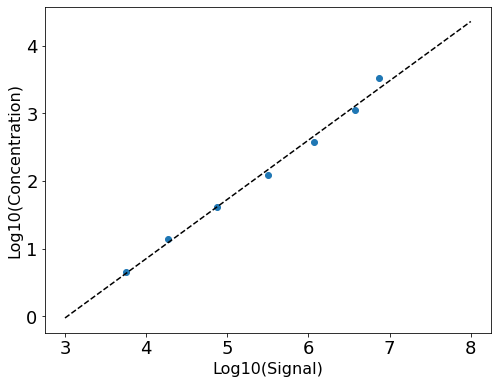

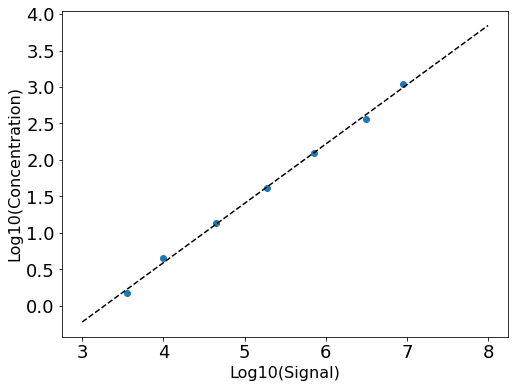

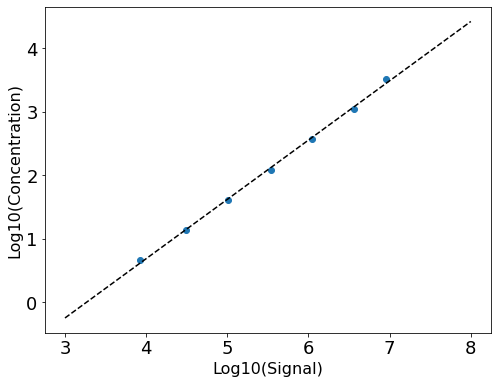

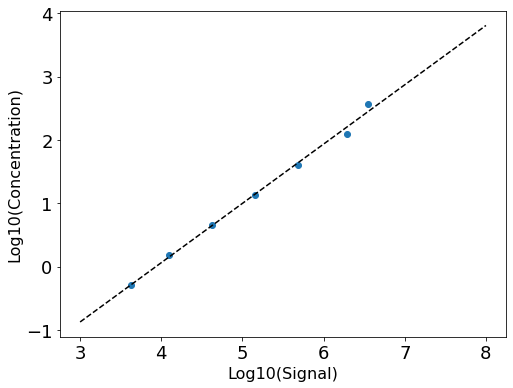

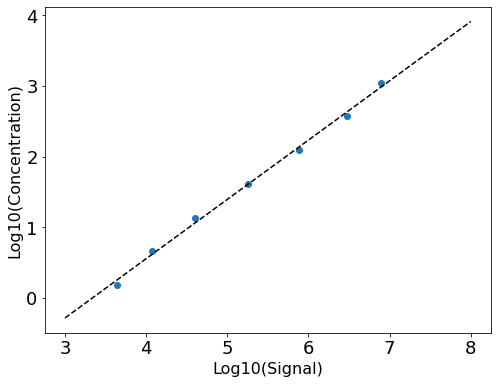

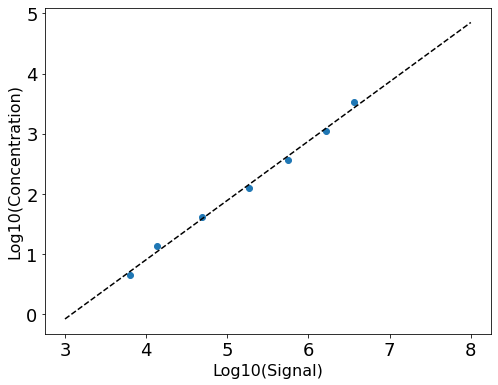

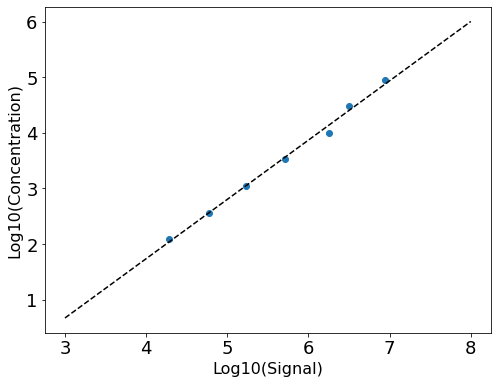

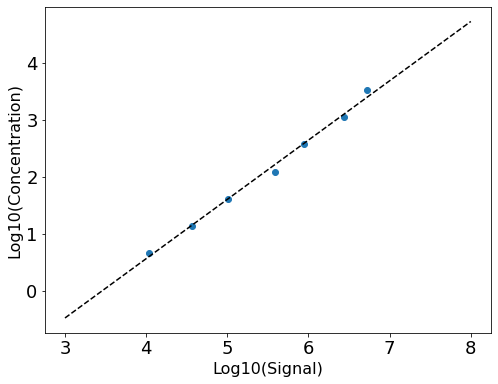

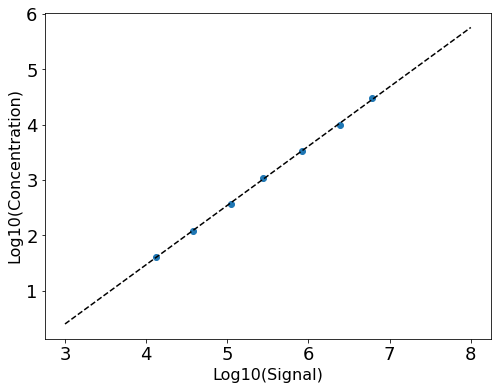

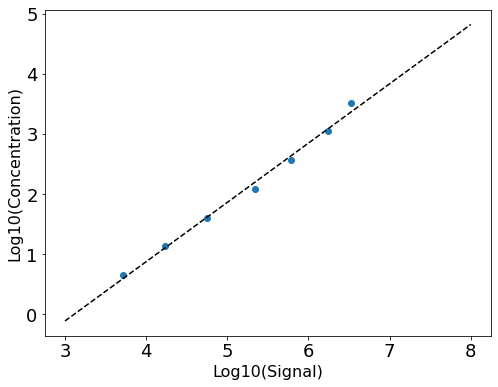

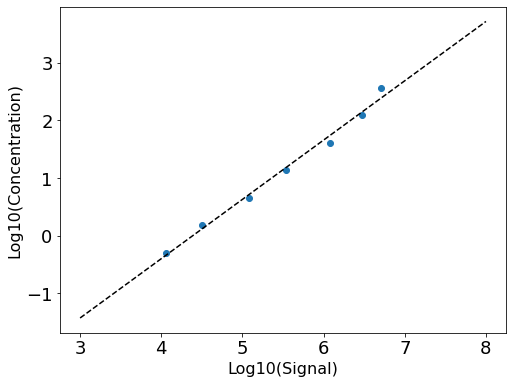

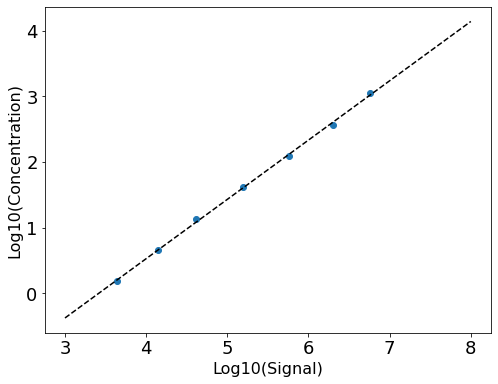

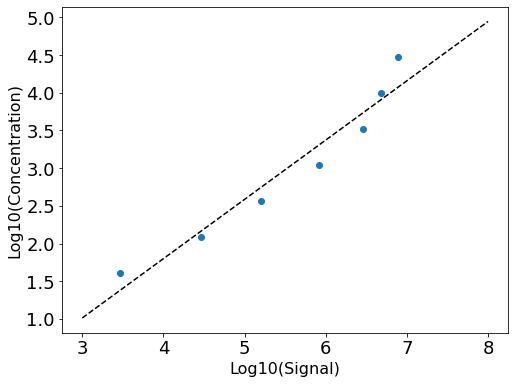

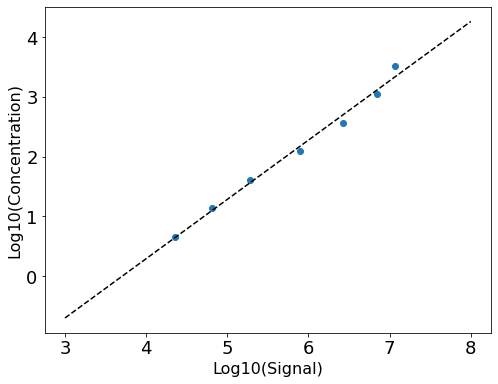

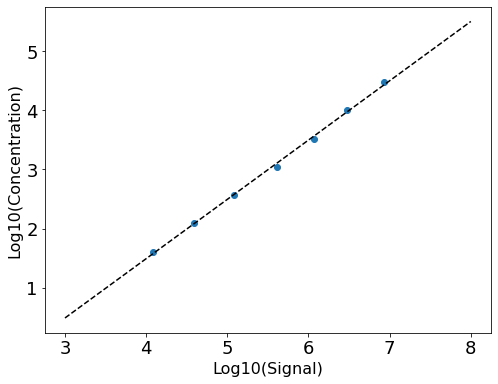

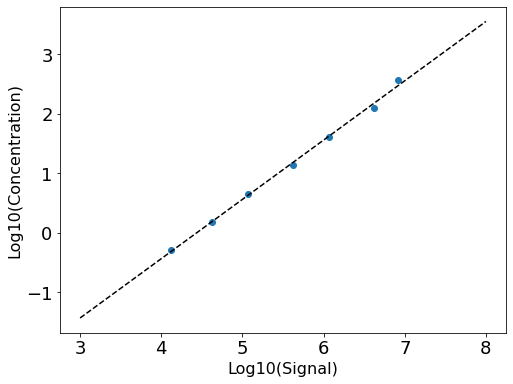

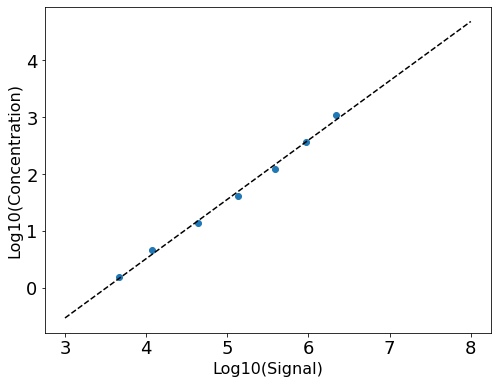

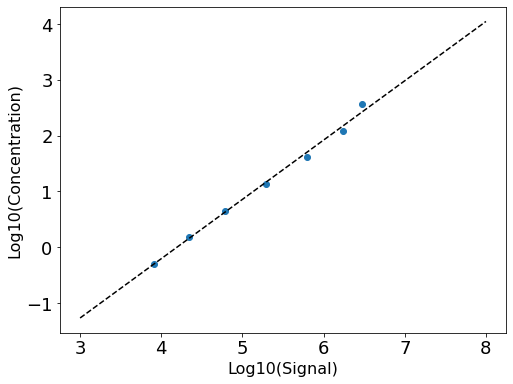

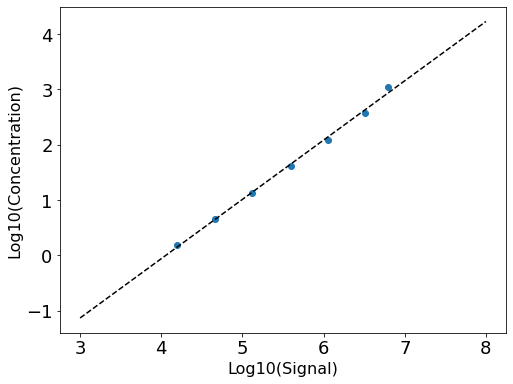

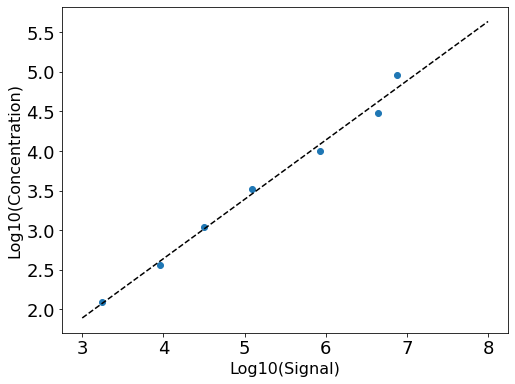

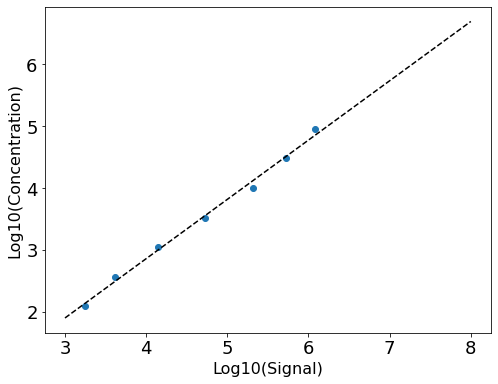

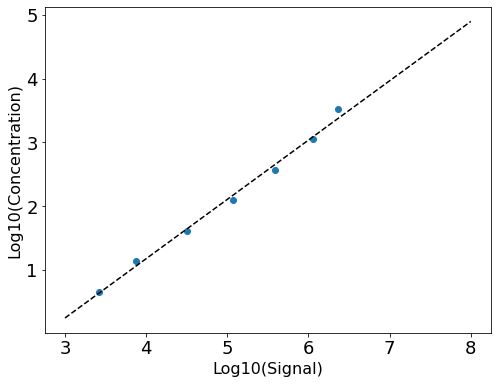

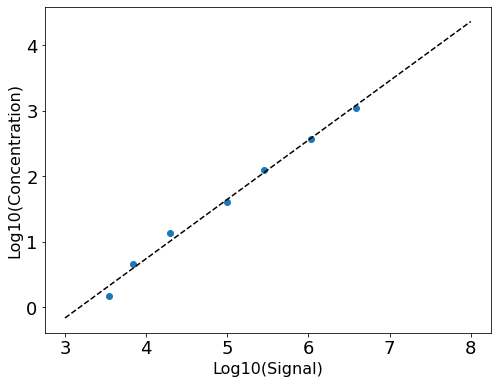

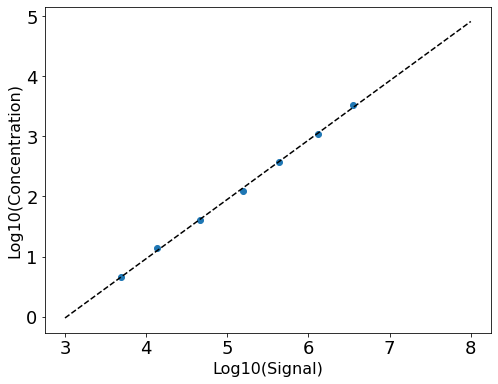

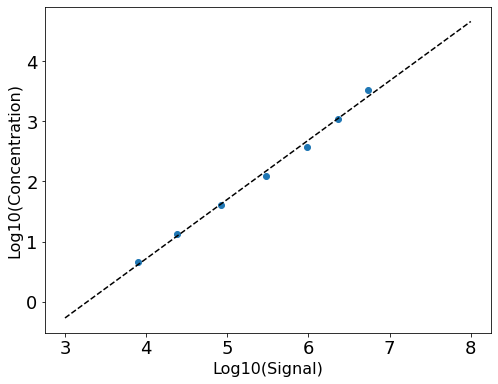

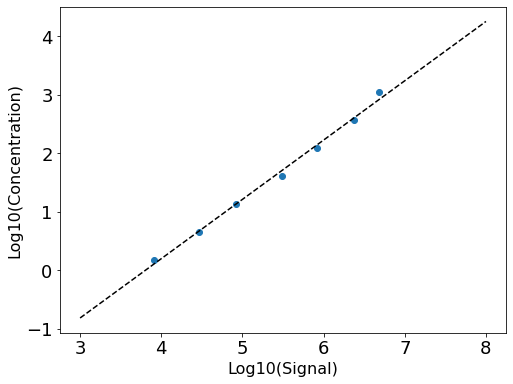

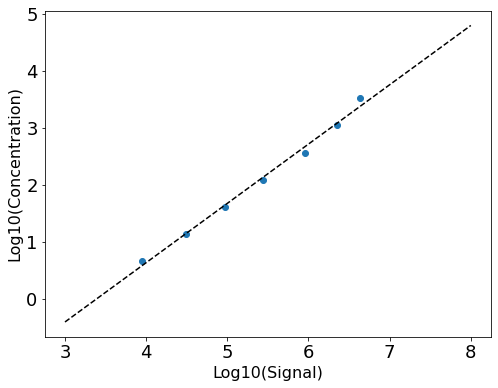

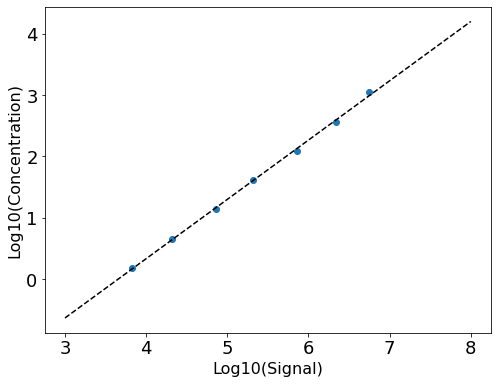

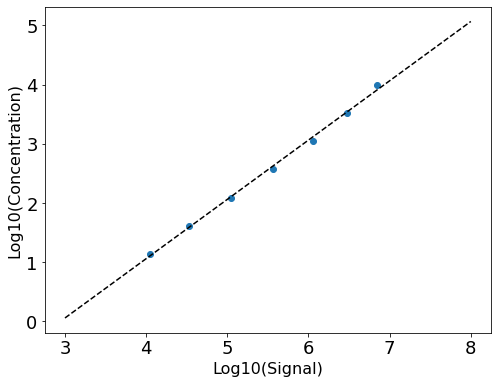

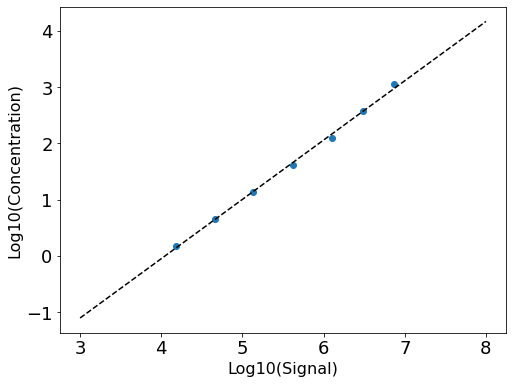

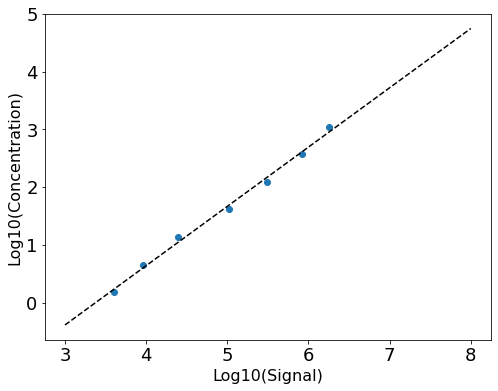

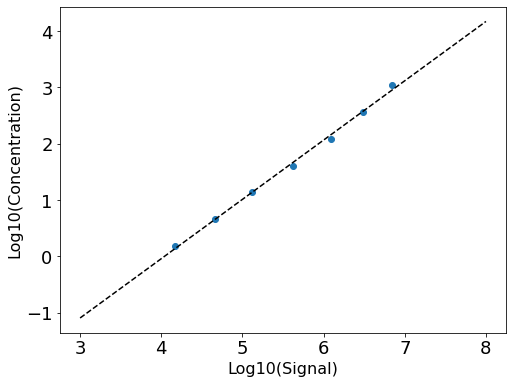

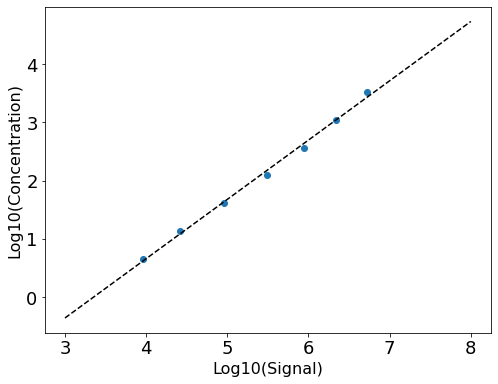

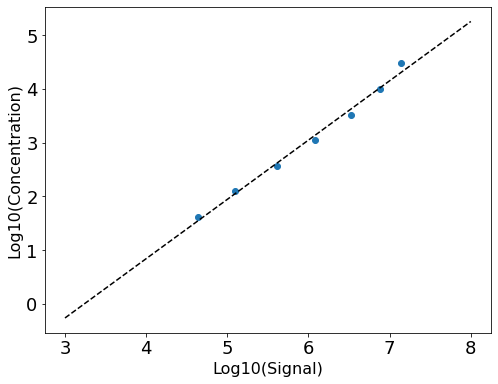

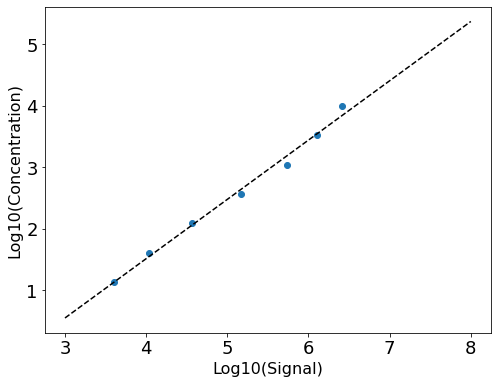

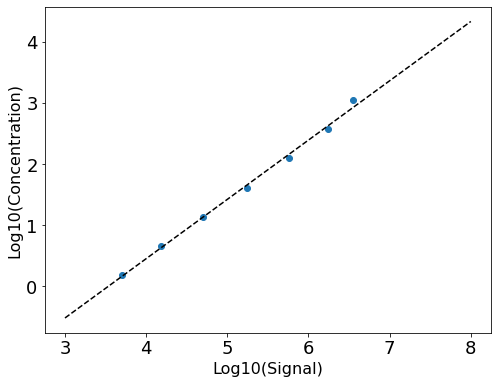

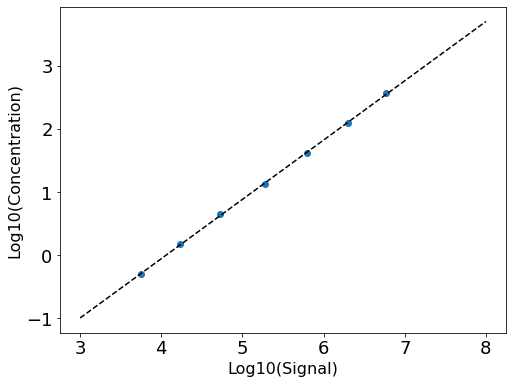

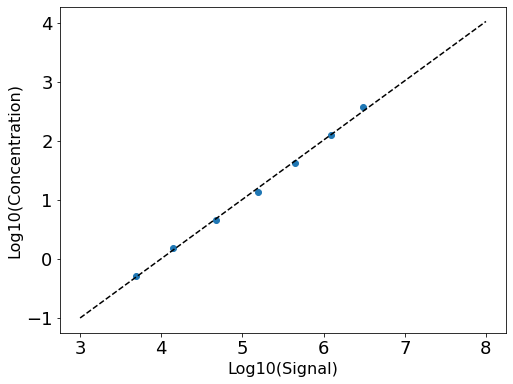

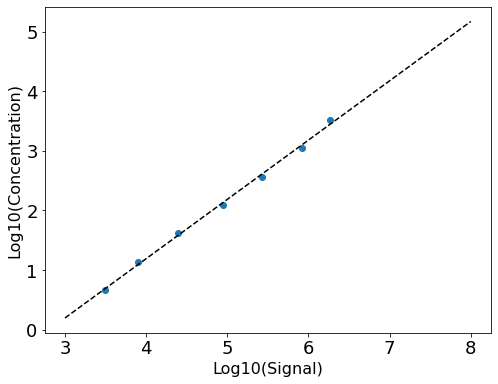

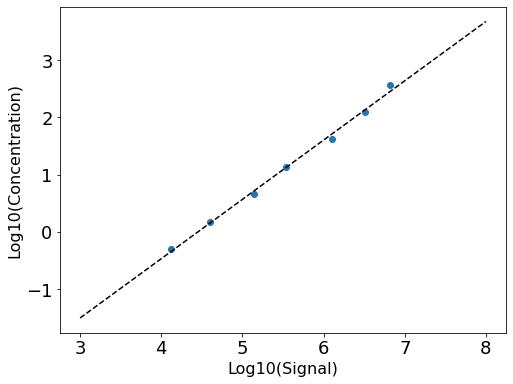

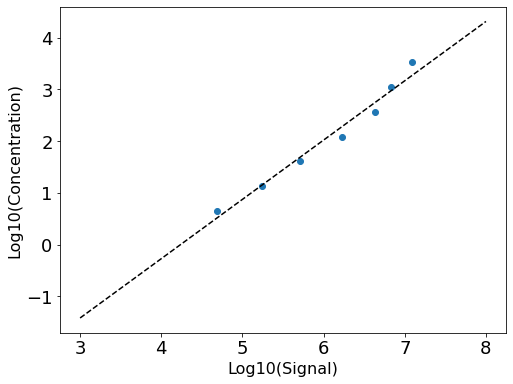

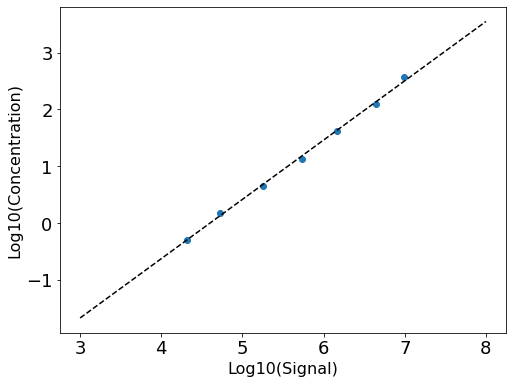

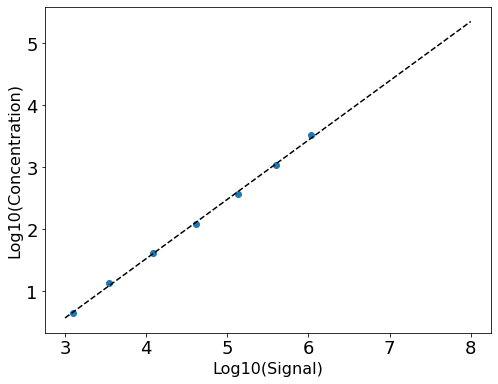

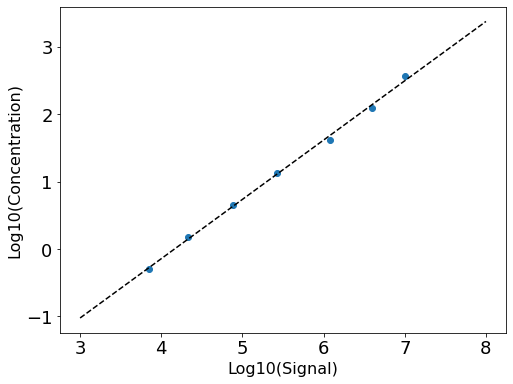

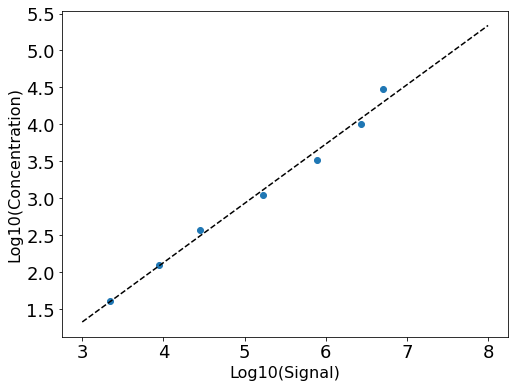

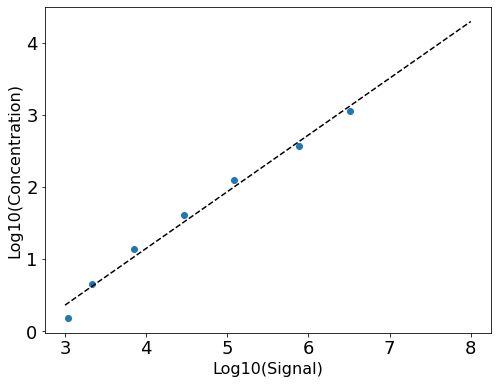

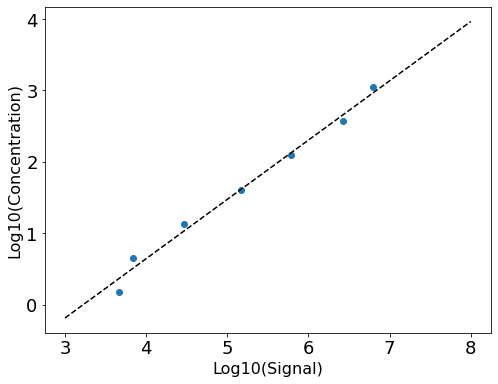

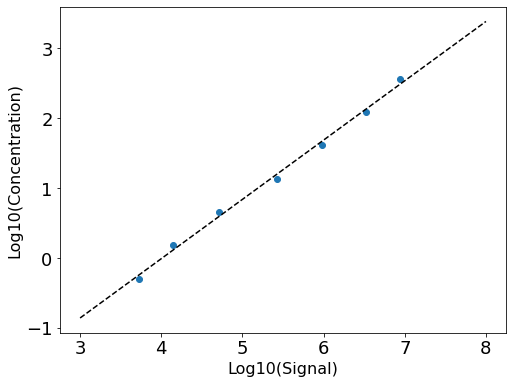

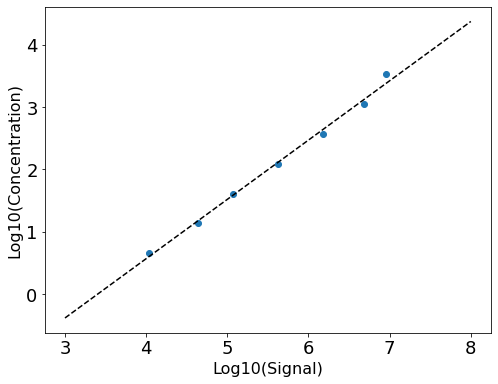

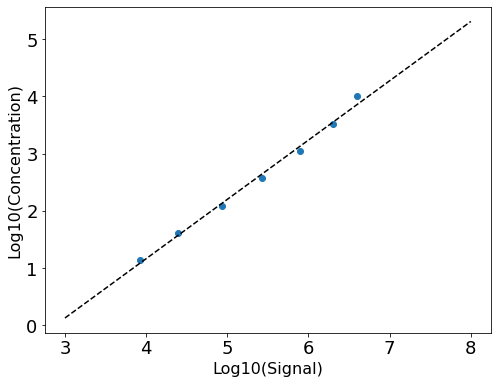

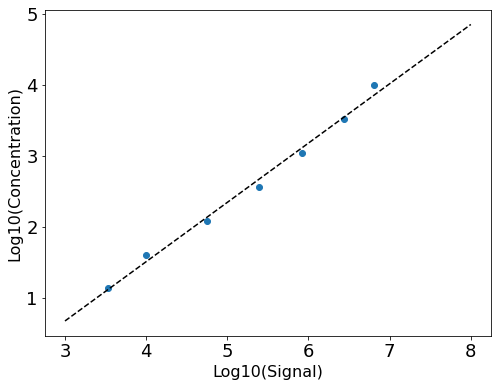

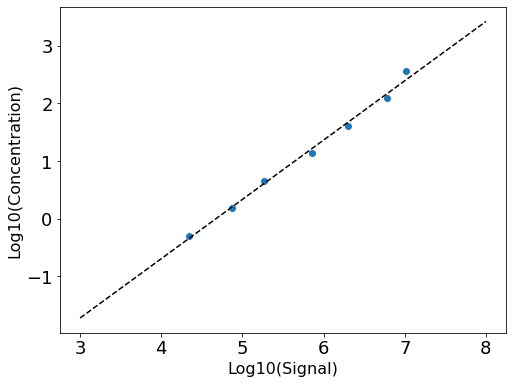

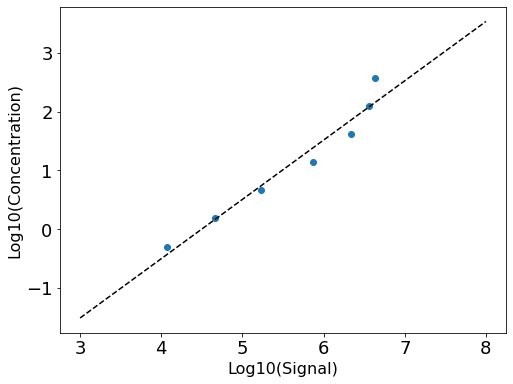

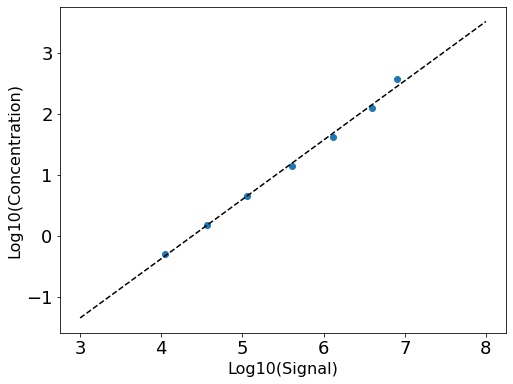

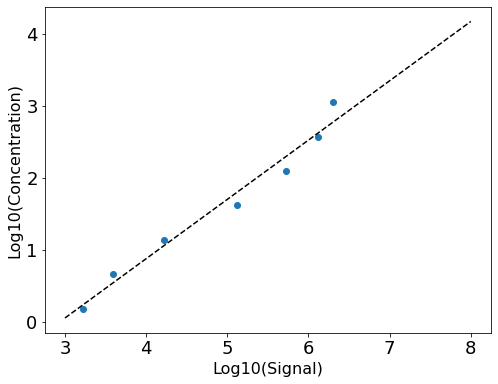

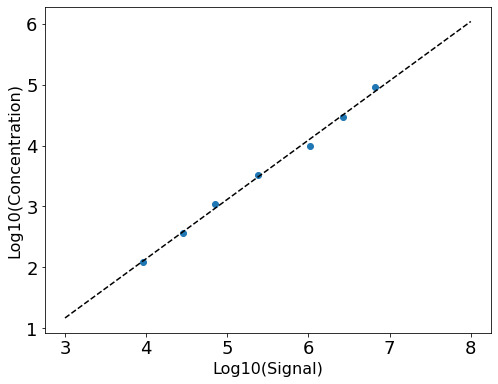

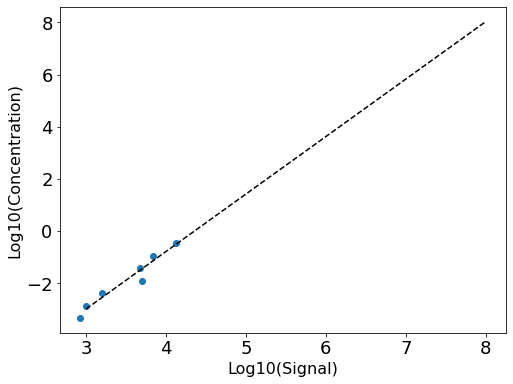

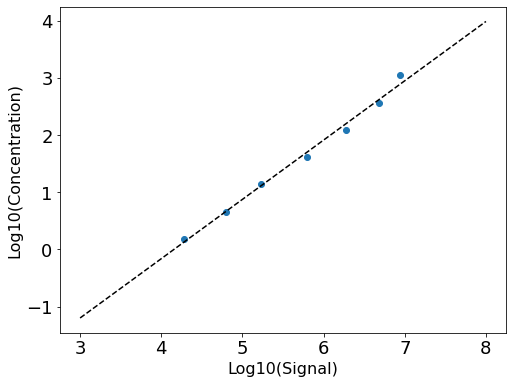

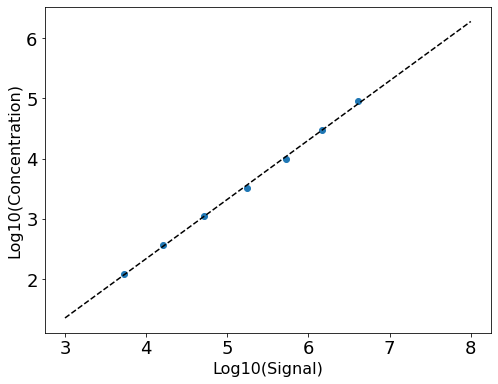

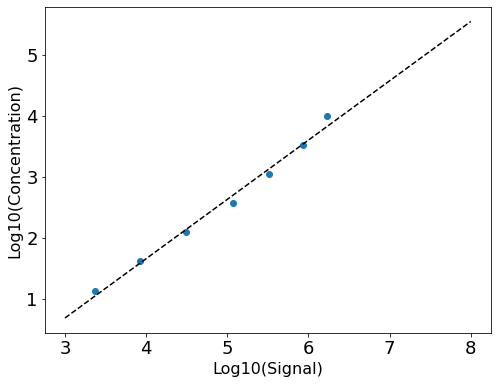

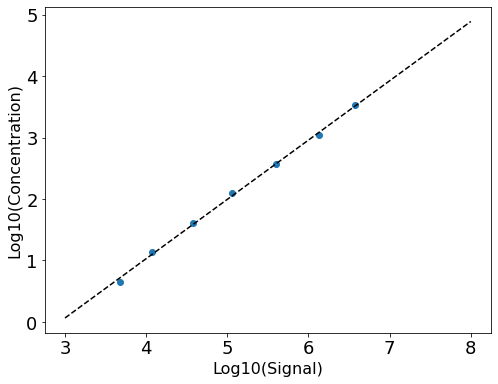

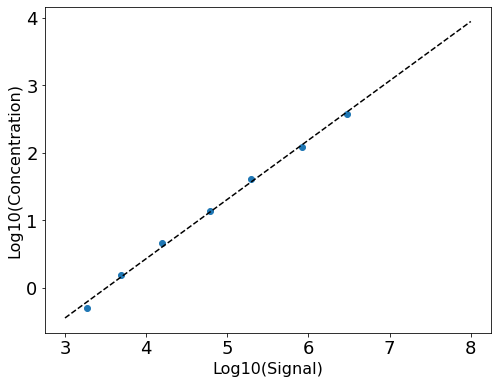

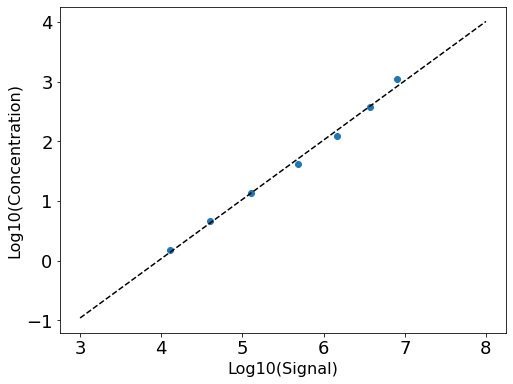

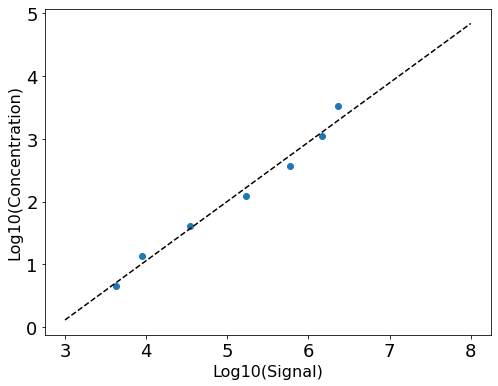

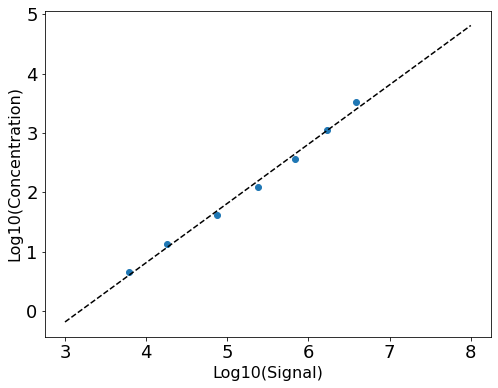

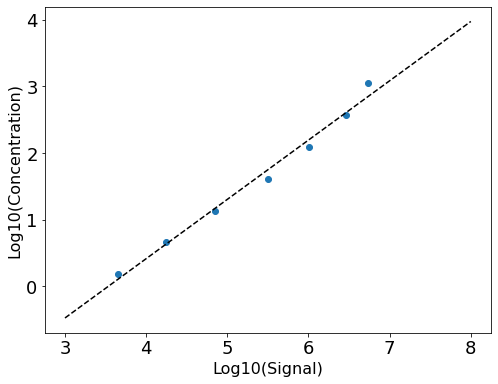

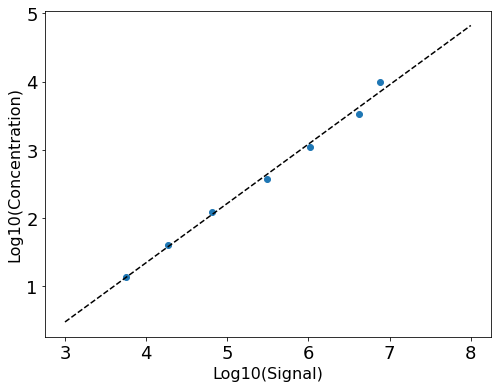

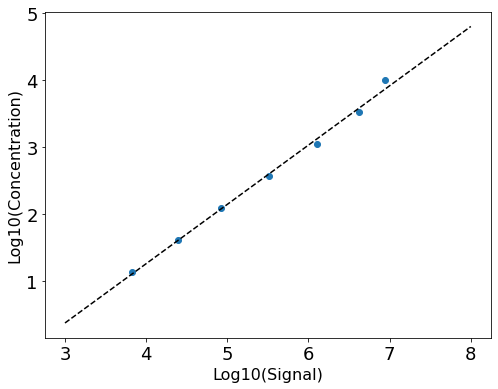

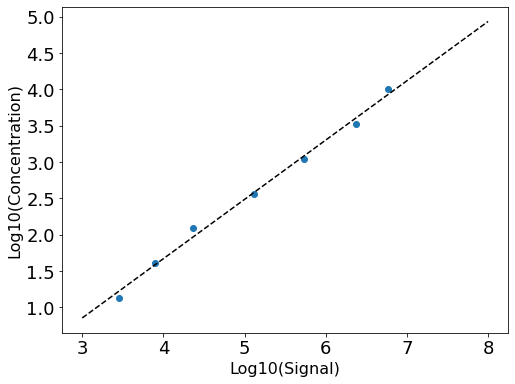

In [39]:
fp70.signal_interpolate(verbose=1)

In [11]:
fp70.pgml[:,10]

array([4653.07056104, 4653.07056104, 4653.07056104, 4653.07056104,
       4653.07056104, 4653.07056104, 4653.07056104, 4653.07056104,
       4653.07056104, 4653.07056104, 4290.3686264 , 4653.07056104,
       3900.51879849, 4653.07056104, 3731.72721143, 4653.07056104,
       3697.58834201, 4653.07056104, 4133.28578023, 4653.07056104,
       2993.7629134 , 4653.07056104, 1906.03373613, 4529.18033692,
       3859.19473012, 4653.07056104, 4653.07056104, 4653.07056104,
       4453.78016913, 4653.07056104, 4653.07056104, 4653.07056104,
       3377.56800206, 4653.07056104, 3699.23392136, 4653.07056104,
       4131.47354077, 4653.07056104, 3134.39986961, 4653.07056104,
       3472.26615363, 4653.07056104, 4653.07056104, 4653.07056104,
       4653.07056104, 4653.07056104, 3765.55757144, 4653.07056104,
       3177.29093454, 4653.07056104, 4653.07056104, 4653.07056104,
       4653.07056104, 4653.07056104, 4653.07056104, 4653.07056104,
       4653.07056104, 4653.07056104, 4653.07056104, 4653.07056

In [36]:
a

array([9.22614285e-03, 6.88022906e+00, 2.74140275e-01, 1.51498262e-02,
       3.71257731e-03, 9.99348303e-01])